In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import torch.nn as nn
import torchvision 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import pandas as pd
import pdb
import os
import cv2
import shutil
import math
import pyrealsense2 as rs
device= 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [3]:

def tranform_tensor(point, center,scale, resolution, inverse=False):

    _pt = torch.tensor([point[0],point[1],1]).view(-1,1).type(torch.FloatTensor)

    h = 200 * scale
    t = torch.eye(3).repeat(len(scale),1,1)
    t[:,0,0] = resolution / h
    t[:,1,1] = resolution / h
    t[:,0,2] = resolution *(-center[:,0]/h + 0.5)
    t[:,1,2] = resolution *(-center[:,1]/h + 0.5)
    if inverse:
        t = torch.inverse(t)

    return torch.matmul(t,_pt)

def crop_and_resize_tensor(imgs, center, scale, resolution=256):
    """"
    function that crops and resizes a batch of images using a center and scale 
    Arguments:
        image {torch.tensor} -- a batch of images. N,C,H,W 
        center {torch.tensor} -- the center of the object, usually the same as of the bounding box
        scale {torch.tensor} -- scale of the face
    Keyword Arguments:
        resolution {float} -- the size of the output cropped image (default: {256.0})
    Returns:
        image {torch.tensor} -- a batch of cropped images. N,C,H,W 
    """
    #todo -- make this work in a batch...
    
    #current size
    N,C,H,W = imgs.shape
    ul_b = tranform_tensor([1,1],center,scale, resolution, inverse = True)
    br_b = tranform_tensor([resolution,resolution],center,scale, resolution, inverse = True)
    out_imgs = torch.zeros((N,C,resolution,resolution))
    for image, ul_t,bl_t, k in zip(imgs,ul_b,br_b, range(N)):
        ul=np.round(ul_t.numpy(),0).astype(np.int)
        br=np.round(bl_t.numpy(),0).astype(np.int)
        newImg = torch.zeros([C,int(br[1]-ul[1]),int(br[0]-ul[0])]).int()
        newX = np.array(
        [max(1, -ul[0] + 1), min(br[0], W) - ul[0]], dtype=np.int32)
        newY = np.array(
        [max(1, -ul[1] + 1), min(br[1], H) - ul[1]], dtype=np.int32)
        oldX = np.array([max(1, ul[0] + 1), min(br[0], W)], dtype=np.int32)
        oldY = np.array([max(1, ul[1] + 1), min(br[1], H)], dtype=np.int32)
        
        #newImg[:,int(newY[0]) - 1:int(newY[1]), int(newX[0]) - 1:int(newX[1])
        #   ] = image[:,int(oldY[0]) - 1:int(oldY[1]), int(oldX[0]) - 1:int(oldX[1])]
        
        newImg[:,int(newY[0]):int(newY[1]), int(newX[0]):int(newX[1])] = image[:,int(oldY[0]):int(oldY[1]), int(oldX[0]):int(oldX[1])]
        out_imgs[k] = nn.functional.interpolate(newImg.unsqueeze_(0).float(), size=(resolution, resolution))
        
        
        
    return out_imgs
    
   # new_image = torch.zeros((N,C,))

def _descale(p, s): return (0.5*(p+1.))*s 

In [4]:
#face detector 
from arch.net_blazeface import BlazeFace
face_detector = BlazeFace()
face_detector.load_state_dict(torch.load('/home/deniz/Code/ClinicalScore/share_mobilenet/pretrained_models/blazeface.pth'))
face_detector.load_anchors_from_npy(np.load('/home/deniz/Code/ClinicalScore/share_mobilenet/pretrained_models/anchors.npy'), device)
#Move model to gpu or cpu 
face_detector.to(device);
#tell Pytorch that you will use the model -- not train the model 
face_detector.eval();

In [5]:
#landmarks finder
from arch.MobileNetV2 import mobilenet_v2
from arch.softargmax import SpatialSoftArgmax2d
class HeadBlock(nn.Module):
    def __init__(self, in_channels, proj_channels, out_channels, **kwargs):
        super(HeadBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, proj_channels, 1, bias=False),
            nn.BatchNorm2d(proj_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(proj_channels, out_channels, 1, bias=False),
            )
        
        self.softargmax = SpatialSoftArgmax2d()
        
    def forward(self, input):
        out = []
        out.append(self.layers(input))
        out.append(self.softargmax(out[-1]))
        return out
    
backbone = mobilenet_v2()
nopoints = 68
head = HeadBlock(152, 152, nopoints)
model_mobilenet = nn.Sequential(backbone, head)
model_mobilenet.load_state_dict(torch.load('/home/deniz/Code/ClinicalScore/share_mobilenet/code/models/models_MobineNet_300W_softmax_pretrainedImagenet/FineTuned_TorontoNeuroFace_Epoch_11.pth'), strict=False)
model_mobilenet.eval();
model_mobilenet.to(device);

In [6]:
avi_path = r'/media/deniz/easystore/facial_tracking_data_2021/mobileNet_lookups.csv'
avi_df = pd.read_csv(avi_path)
avi_df = avi_df.drop("Unnamed: 0", axis=1)
avi_df.head()

,subject,task,date,avi_path
0,AF01,OPEN,20170509,/media/deniz/easystore/facial_tracking_data_20...
1,AF01,OPEN,20170509,/media/deniz/easystore/facial_tracking_data_20...
2,AF01,SPREAD,20170509,/media/deniz/easystore/facial_tracking_data_20...
3,AF01,SPREAD,20170509,/media/deniz/easystore/facial_tracking_data_20...
4,AF01,PUCKER,20170509,/media/deniz/easystore/facial_tracking_data_20...


In [3]:
avi_path = r'/media/deniz/easystore/facial_tracking_data_2021/rest_files.csv'
avi_df = pd.read_csv(avi_path)
avi_df = avi_df.drop("Unnamed: 0", axis=1)
avi_df.head()



,avi_path
0,/media/deniz/easystore/facial_tracking_data_20...
1,/media/deniz/easystore/facial_tracking_data_20...
2,/media/deniz/easystore/facial_tracking_data_20...
3,/media/deniz/easystore/facial_tracking_data_20...
4,/media/deniz/easystore/facial_tracking_data_20...


In [4]:
len(avi_df)

134

In [11]:
avi_df['avi_path'][6]

'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF07_SBK_20170530/02/RSSDK/AF07_02_20170530_RST_REST_color.avi'

In [12]:
avi_df= avi_df[7:]

In [13]:
avi_df.head()

,avi_path
7,/media/deniz/easystore/facial_tracking_data_20...
8,/media/deniz/easystore/facial_tracking_data_20...
9,/media/deniz/easystore/facial_tracking_data_20...
10,/media/deniz/easystore/facial_tracking_data_20...
11,/media/deniz/easystore/facial_tracking_data_20...


In [8]:

#population = ['ALS', 'PLS', 'Kennedys', 'Post-stroke', 'Healthy_Control']

#tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE' , 'RST_REST', 'NSM_KISS', 'NSM_PUCKER', 'DDK_PA']

#tasks = ['RST_REST']


base_path = '/media/deniz/easystore/facial_tracking_data_2021'
output_subfolder = 'LANDMARKS/mobileNet'
sufix = '_landmarksPixels2D.csv'

In [14]:
st=time.time()
#transforms 
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])


error_avi = []

for index, row in avi_df.iterrows():
     
    
    color_file = row['avi_path']
    
    
    print('Starting: ', color_file)
    print()
    splited_name = color_file.split('/')
    name = splited_name[-1][:-4]
    root_path = '/'.join(splited_name[:-2])
    
    folder  = os.path.join(root_path,output_subfolder)
    csv_name = os.path.join(folder, name + sufix)
    
    #if os.path.exists(csv_name):
    #    continue 
        
    if not os.path.exists(folder):
        os.makedirs(folder)
    vid = torchvision.io.read_video(color_file, pts_unit='sec')
    
    
    try: 
        #create batches
        idx = np.arange(vid[0].shape[0])
        batch_size=200
        q = int(idx.shape[0] / batch_size)
        block_end = q * batch_size
        batch_idx = np.split(idx[:block_end], q) + [idx[block_end:]]

        F,H,W,C = vid[0].shape
        landmarks = np.zeros((F,68,2))
        o_landmarks = np.zeros((F,68,2))
        c = np.zeros((F,2))
        s = np.zeros((F,))
        #this for facial localization 
        des_dim = 128
        yshift, xshift = 0, (H-W)//2
        xstart = (int(W*(128/H))-des_dim)//2

        ref_scale = 195 #adjust this value to have the face smaller or bigger in the image
        resolution = 256
        vid_crop = torch.zeros((F,C,resolution,resolution))

        with torch.no_grad():
            for batch in batch_idx:

                imgs = vid[0][batch,:,:,:]
                imgs = imgs.permute(0,3,1,2)#.type(torch.FloatTensor)
                imgs_bf = nn.functional.interpolate(imgs, (des_dim, int(W*(des_dim/H))))
                imgs_bf = imgs_bf[:,:,:, xstart:xstart+128]

                bboxes = torch.cat(face_detector.predict_on_batch(imgs_bf.to(device)))
                face_locs = torch.cat((bboxes[:,1:2], bboxes[:,0:1], bboxes[:,3:4], bboxes[:,2:3]), dim=1) * H + torch.tensor([int((W-H)/2), 0, int((W-H)/2), 0]) 


                centersx = face_locs[:,2] - (face_locs[:,2]-face_locs[:,0])/2
                centersy = (face_locs[:,3] - (face_locs[:,3]-face_locs[:,1])/2) - (face_locs[:,3]-face_locs[:,1])*0.12
                centers = torch.cat((centersx.view(-1,1),centersy.view(-1,1)), dim=1)

                scales = ((face_locs[:,2]-face_locs[:,0]) + (face_locs[:,3]-face_locs[:,1]))/ref_scale

                #if using FAN, do this
                #imgs_norm = (imgs.div_(255)
                #if using other models do this


                imgs_crop = crop_and_resize_tensor(imgs, centers, scales, resolution=resolution)
                vid_crop[batch] = imgs_crop
                imgs_crop = (imgs_crop.div(255)-MEAN[None,:,None,None]) / STD[None,:,None,None]

                outs = model_mobilenet(imgs_crop.to(device))
                landmarks[batch,:,:] = outs[-1].cpu().numpy()
                c[batch,:] = centers.cpu().numpy()
                s[batch] = scales.cpu().numpy()

        landmarks = _descale(landmarks,resolution)


        
        for f in range(landmarks.shape[0]):

            h = 200 * s[f]
            t = torch.eye(3)
            t[0,0] = resolution / h
            t[1,1] = resolution / h
            t[0,2] = resolution *(-c[f,0]/h + 0.5)
            t[1,2] = resolution *(-c[f,1]/h + 0.5)
            t = torch.inverse(t)

            for l in range(landmarks.shape[1]):
                point = landmarks[f,l,:]
                _pt = torch.tensor([point[0],point[1],1]).view(-1,1).type(torch.FloatTensor)

                original = torch.matmul(t,_pt)
                #print(original.shape)
                original =  original[0:-1,:]
                original = original.reshape(2,)
                #print(original.shape)
                o_landmarks[f,l,:] = original


        #create a dataframe that will store all the information 
        df_cols = []
        #y_col = []
        #x_col = []
        for i in range(0,68):
            num=str(i)
            xx = 'landmark_'+num+'_x'
            yy = 'landmark_'+num+'_y'
            #x_col.append(xx)
            #y_col.append(yy)
            df_cols.append(xx)
            df_cols.append(yy)
        l = o_landmarks.reshape(o_landmarks.shape[0],-1)
        LandmarkDataFrame = pd.DataFrame(l,columns = df_cols)
        LandmarkDataFrame["fps"]=vid[2].get('video_fps')
        LandmarkDataFrame.to_csv(csv_name)
        
    except Exception as e:
        print(e)
        #break
    #except:
    #    print("ERROR OCCURTED")
    #    print()
        error_avi.append(color_file)
        pass
   

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF08_SBK_20170606/02/RSSDK/AF08_02_20170606_RST_REST_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF09_SBK_20170613/02/RSSDK/AF09_02_20170613_RST_REST_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF10_SBK_20170613/02/RSSDK/AF10_02_20170613_RST_REST_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF11_SBK_20170928/02/RSSDK/AF11_02_20170928_RST_REST_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF11_SBK_20170928/02/RSSDK/AF11_02_20170928_RST_REST_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF12_SBK_20180731/02/RSSDK/AF12_02_20180731_RST_REST2_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF13_SBK_20190110/02/RSSDK/A013_02_20190110_RST_REST3_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF13_SBK_20190110/02/RSSDK/A013_02_201

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP12_SBK_20191107/02/RSSDK/OP12_02_20191107_RST_REST2_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP12_SBK_20191206/02/RSSDK/OP12_02_20191206_RST_REST2_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP13_SBK_20200117/02/RSSDK/OP13_02_20200117_RST_REST2_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP13_SBK_20200117/02/RSSDK/OP13_02_20200117_RST_REST2_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP13_SBK_20200117/02/RSSDK/OP13_02_20200117_RST_REST2_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP13_SBK_20200117/02/RSSDK/OP13_02_20200117_RST_REST2_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP13_SBK_20200117/02/RSSDK/OP13_02_20200117_RST_REST2_color.avi

Starting:  /media/deniz/easystore/facial_

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF22_TRI_20190709/02/RSSDK/NF22_02_20190709_RST_REST2_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF22_TRI_20190709/02/RSSDK/NF22_02_20190709_RST_REST2_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF23_TRI_20190808/02/RSSDK/NF23_02_20190808_RST_REST3_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF24_TRI_20190826/02/RSSDK/NF24_02_20190826_RST_REST2_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF25_SBK_20190815/02/RSSDK/NF25_02_20190815_RST_REST2_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20190829/02/RSSDK/NF26_02_20190829_RST_REST2_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20190829/02/RSSDK/NF26_02_20190829_RST_REST2_color.avi

Starting:  /m

In [15]:
print(len(error_avi))
error_avi

6


['/media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP18_SBK_20200811/02/RSSDK/OP18_02_20200811_RST_REST1_1451.avi',
 '/media/deniz/easystore/facial_tracking_data_2021/Post-stroke/S013_TRI_20180302/02/RSSDK/S013_02_20180302_RST_REST2_color.avi',
 '/media/deniz/easystore/facial_tracking_data_2021/Post-stroke/S013_TRI_20180302/02/RSSDK/S013_02_20180302_RST_REST2_color.avi',
 '/media/deniz/easystore/facial_tracking_data_2021/Post-stroke/S013_TRI_20180302/02/RSSDK/S013_02_20180302_RST_REST2_color.avi',
 '/media/deniz/easystore/facial_tracking_data_2021/Post-stroke/S013_TRI_20180302/02/RSSDK/S013_02_20180302_RST_REST2_color.avi',
 '/media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF05_SBK20170526/02/RSSDK/NF05_02_SBK20170526_RST_REST_depth.avi']

In [6]:
path = r'/media/deniz/easystore/facial_tracking_data_2021/mobileNet_error_files.csv'

df = pd.DataFrame(error_avi,columns =['error_avi'])

df.to_csv(path)


NameError: name 'error_avi' is not defined

# Get 3d VALUES 

In [3]:
# working get 3D metric values of the 68 landmarks for .bag files 

def get3dlandmarks(BAG_File, info_file, csv_file):

    DF_landmarks = pd.read_csv(csv_file, index_col=0)

    DF_info = pd.read_csv(info_file, index_col=0)


    # create dataframe to store information about 3d position of landmarks
    df_cols_p1 = ['Time_Stamp (s)']
    for i in range(0, 68):
        num = str(i)
        xx = 'landmark_' + num
        df_cols_p1.append(xx)
        df_cols_p1.append(xx)
        df_cols_p1.append(xx)

    df_cols_p2 = [""]
    for i in range(0, 68):
        df_cols_p2.append("x")
        df_cols_p2.append("y")
        df_cols_p2.append("z")

    header = [np.array(df_cols_p1),
              np.array(df_cols_p2)]

    DF_3dpositions = pd.DataFrame(columns=header)

    DF_3dpositions['Time_Stamp (s)'] = DF_info['Frame_Time_Stamp']
    #DF_3dpositions['Video_Frame_number'] = DF_landmarks['Video_Frame_number']

    # start the process of extracting the video information for each video
    pipeline = rs.pipeline()
    config = rs.config()

    rs.config.enable_device_from_file(config, BAG_File, repeat_playback=False)

    config.enable_all_streams()
    profile = pipeline.start(config)

    # create alignment object
    align_to = rs.stream.color
    align = rs.align(align_to)

    # Getting the depth sensor's depth scale (see rs-align example for explanation)
    depth_sensor = profile.get_device().first_depth_sensor()
    depth_scale = depth_sensor.get_depth_scale()

    # inform the device that this is not live streaming from camera
    playback = profile.get_device().as_playback()
    playback.set_real_time(False)
    duration = playback.get_duration()

    # fill holes in the depth information (based on this example: https://nbviewer.jupyter.org/github/IntelRealSense/librealsense/blob/jupyter/notebooks/depth_filters.ipynb)
    spatial = rs.spatial_filter()
    spatial.set_option(rs.option.filter_magnitude, 2)
    spatial.set_option(rs.option.filter_smooth_alpha, 0.5)
    spatial.set_option(rs.option.filter_smooth_delta, 20)
    spatial.set_option(rs.option.holes_fill, 3)

    true_frame_number = []
    frame_number = []
    time_st = []

    num_frame = 0

    try:
        while True:
            frames = pipeline.wait_for_frames()

            this_frame = frames.get_frame_number()  # get frame number        
            landmarks=None
            # verify that we have landmarks for this particular frame

            try:
                vid_frame = DF_info.Frame_Number_in_Video.loc[DF_info["BAG_Frame_Number"]==this_frame].values[0] 

                index_ = DF_info.index[DF_info['BAG_Frame_Number']==this_frame]

                landmarks = DF_landmarks.iloc[index_].values[0][:-1]
                #print(landmarks)
                landmarks = landmarks.astype('float').reshape(-1, 2)
                aligned_frames = align.process(frames)

                # take color and depth from frame, if any to these is not available then skip the frame
                aligned_frames = align.process(frames)

                # take color and depth from frame, if any to these is not available then skip the frame
                aligned_depth = aligned_frames.get_depth_frame()
                aligned_color = aligned_frames.get_color_frame()

                # validate that both frames are available
                if not aligned_depth or not aligned_color:
                    continue

                #time_stamp = frames.get_timestamp()
                #true_frame_number.append(frames.get_frame_number())
                #time_st.append(time_stamp)
                #frame_number.append(num_frame)

                # Intrinsics & Extrinsics
                depth_intrin = aligned_depth.profile.as_video_stream_profile().intrinsics
                color_intrin = aligned_depth.profile.as_video_stream_profile().intrinsics
                depth_to_color_extrin = aligned_depth.profile.get_extrinsics_to(aligned_color.profile)

                aligned_filtered_depth = spatial.process(aligned_depth)
                depth_frame_array = np.asanyarray(aligned_filtered_depth.as_frame().get_data())
                depth_frame_array = depth_frame_array * depth_scale

                coords = []

                for (c,
                     r) in landmarks:  # landmarks provide the x,y position of each landmark. x are columns and y are rows in the figure
                    # depth_value = depth_frame.get_distance(int(c),int(r))
                    # x,y,z = rs.rs2_deproject_pixel_to_point(depth_intrin, [int(c), int(r)], depth_value)
                    try:
                        depth_value = depth_frame_array[int(r), int(c)]
                    except IndexError:
                        h,w = depth_frame_array.shape
                        if r>w-1:r=h-1
                        if c>h-1:c=w-1
                        depth_value = depth_frame_array[int(r), int(c)]

                    z = depth_value
                    x = z * ((c - depth_intrin.ppx) / depth_intrin.fx)
                    y = z * ((r - depth_intrin.ppy) / depth_intrin.fy)
                    coords.append(x), coords.append(y), coords.append(z)

                DF_3dpositions.loc[index_,1:] =coords
                
            except IndexError:
                error= 'Error file:' + BAG_File.split(os.path.sep)[-1] +'\n' + str(this_frame)+' does not exists in color video'
                print(error)
                continue


    except RuntimeError:
        pass
    finally:
        pipeline.stop()
        
    DF_3dpositions['depth_scale'] = depth_scale  
    landmark_file = csv_file[:-12]+'3D.csv'
    DF_3dpositions.to_csv(landmark_file)

In [4]:
bag_path = r'/media/deniz/easystore/facial_tracking_data_2021/all_bag_files_for_clinical_score.csv'
bag_df = pd.read_csv(bag_path)
bag_df = bag_df.drop("Unnamed: 0", axis=1)
bag_df.head()

,subID,Date,task,bag_path
0,AF12,20180731,PUCKER,/media/deniz/easystore/facial_tracking_data_20...
1,AF12,20180731,OPEN,/media/deniz/easystore/facial_tracking_data_20...
2,AF12,20180731,SPREAD,/media/deniz/easystore/facial_tracking_data_20...
3,AF12,20180731,REST,/media/deniz/easystore/facial_tracking_data_20...
4,AF12,20180731,REST,/media/deniz/easystore/facial_tracking_data_20...


In [7]:
len(bag_df)

714

In [20]:
bag_df['bag_path'][668]

'/media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF22_TRI_20200220/02/RSSDK/NF22_02_20200220_NSM_SPREAD_1432-NotWorking.bag'

In [21]:
bag_df = bag_df[669:]

In [5]:
rest_df = bag_df[bag_df['task'] == 'REST']
len(rest_df)

203

In [27]:
rest_df.head()

,subID,Date,task,bag_path
3,AF12,20180731,REST,/media/deniz/easystore/facial_tracking_data_20...
4,AF12,20180731,REST,/media/deniz/easystore/facial_tracking_data_20...
8,A013,20190110,REST,/media/deniz/easystore/facial_tracking_data_20...
10,AF13,20190110,REST,/media/deniz/easystore/facial_tracking_data_20...
11,AF13,20190110,REST,/media/deniz/easystore/facial_tracking_data_20...


In [16]:
rest_df['bag_path'].loc[rest_df['subID'] == 'OP12']

408    /media/deniz/easystore/facial_tracking_data_20...
409    /media/deniz/easystore/facial_tracking_data_20...
410    /media/deniz/easystore/facial_tracking_data_20...
417    /media/deniz/easystore/facial_tracking_data_20...
418    /media/deniz/easystore/facial_tracking_data_20...
419    /media/deniz/easystore/facial_tracking_data_20...
427    /media/deniz/easystore/facial_tracking_data_20...
428    /media/deniz/easystore/facial_tracking_data_20...
429    /media/deniz/easystore/facial_tracking_data_20...
Name: bag_path, dtype: object

In [17]:
rest_df = rest_df.drop([51,121,409])

In [18]:
rest_df.head()

,subID,Date,task,bag_path
3,AF12,20180731,REST,/media/deniz/easystore/facial_tracking_data_20...
4,AF12,20180731,REST,/media/deniz/easystore/facial_tracking_data_20...
8,A013,20190110,REST,/media/deniz/easystore/facial_tracking_data_20...
10,AF13,20190110,REST,/media/deniz/easystore/facial_tracking_data_20...
11,AF13,20190110,REST,/media/deniz/easystore/facial_tracking_data_20...


In [19]:
sufix = '_landmarks3D.csv'
pixel_sufix = '_color_landmarksPixels2D.csv'
info_sufix = '_frameInfoColor.csv'
output_subfolder = 'LANDMARKS/mobileNet'
TIMEOUT = 200


for index, row in rest_df.iterrows():
    #print(row)
    BAG_File = row['bag_path']
    splited_name = row['bag_path'].split('/')
    name = splited_name[-1][:-4]
    root_path = '/'.join(splited_name[:-2])
    
    # output foler which is the mobileNet
    folder  = os.path.join(root_path,output_subfolder)
    
    # the name of the csv file that has the 2d pixel values of landmarks 
    csv_name = os.path.join(folder, name + pixel_sufix)
    print(BAG_File)
    #print(csv_name)
    
    # the frame info csv
    info_name = os.path.join('/'.join(splited_name[:-1]), name + info_sufix)
    #print(info_name)
    
    
    landmark_file = csv_name[:-12]+'3D.csv'
    print(landmark_file)
    
    if os.path.exists(landmark_file):
        continue
    
    if not os.path.exists(csv_name):
        print('here')
        print()
        continue 
        
    if not os.path.exists(info_name):
        print('here2')
        print()
        continue
    
    
    
    
    try:
        get3dlandmarks(BAG_File, info_name, csv_name)
        print('DONE')
        print()
    
    except: 
        print('here3')
        continue
        
    if 0:
        try:
            print('here3')
            print()
            q = Process(target=get3dlandmarks, args=(BAG_File, info_name, csv_name,))
            q.start()
            q.join(TIMEOUT)
            if q.is_alive():
                print('TIME OUT!')
                print()
                q.terminate()
                q.join()


        except: 
            continue
            
    #get3dlandmarks(BAG_File, info_name, csv_name)

/media/deniz/easystore/facial_tracking_data_2021/ALS/AF12_SBK_20180731/02/RSSDK/AF12_02_20180731_RST_REST.bag
/media/deniz/easystore/facial_tracking_data_2021/ALS/AF12_SBK_20180731/02/LANDMARKS/mobileNet/AF12_02_20180731_RST_REST_color_landmarks3D.csv
here

/media/deniz/easystore/facial_tracking_data_2021/ALS/AF12_SBK_20180731/02/RSSDK/AF12_02_20180731_RST_REST2.bag
/media/deniz/easystore/facial_tracking_data_2021/ALS/AF12_SBK_20180731/02/LANDMARKS/mobileNet/AF12_02_20180731_RST_REST2_color_landmarks3D.csv
/media/deniz/easystore/facial_tracking_data_2021/ALS/AF13_SBK_20190110/02/RSSDK/A013_02_20190110_RST_REST3.bag
/media/deniz/easystore/facial_tracking_data_2021/ALS/AF13_SBK_20190110/02/LANDMARKS/mobileNet/A013_02_20190110_RST_REST3_color_landmarks3D.csv
here2

/media/deniz/easystore/facial_tracking_data_2021/ALS/AF13_SBK_20190110/02/RSSDK/AF13_02_20190110_RST_REST2.bag
/media/deniz/easystore/facial_tracking_data_2021/ALS/AF13_SBK_20190110/02/LANDMARKS/mobileNet/AF13_02_20190110_RST_R

DONE

/media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP12_SBK_20191107/02/RSSDK/OP12_02_20191107_RST_REST3.bag
/media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP12_SBK_20191107/02/LANDMARKS/mobileNet/OP12_02_20191107_RST_REST3_color_landmarks3D.csv
here

/media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP12_SBK_20191206/02/RSSDK/OP12_02_20191206_RST_REST.bag
/media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP12_SBK_20191206/02/LANDMARKS/mobileNet/OP12_02_20191206_RST_REST_color_landmarks3D.csv
here

/media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP12_SBK_20191206/02/RSSDK/OP12_02_20191206_RST_REST2.bag
/media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP12_SBK_20191206/02/LANDMARKS/mobileNet/OP12_02_20191206_RST_REST2_color_landmarks3D.csv
DONE

/media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP12_SBK_20191206/02/RSSDK/OP12_02_20191206_RST_REST3.bag
/media/deniz/easystore/facial_tracking_data_2021/

DONE

/media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF13_TRI_20190328/02/RSSDK/NF13_02_20190328_RST_REST3.bag
/media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF13_TRI_20190328/02/LANDMARKS/mobileNet/NF13_02_20190328_RST_REST3_color_landmarks3D.csv
here

/media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF14_TRI_20190404/02/RSSDK/NF14_02_20190404_RST_REST.bag
/media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF14_TRI_20190404/02/LANDMARKS/mobileNet/NF14_02_20190404_RST_REST_color_landmarks3D.csv
here

/media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF14_TRI_20190404/02/RSSDK/NF14_02_20190404_RST_REST2.bag
/media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF14_TRI_20190404/02/LANDMARKS/mobileNet/NF14_02_20190404_RST_REST2_color_landmarks3D.csv
DONE

/media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF14_TRI_20190404/02/RSSDK/NF14_02_20190404_RST_REST3.bag
/media/deniz/easystor

DONE

/media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF24_TRI_20190826/02/RSSDK/NF24_02_20190826_RST_REST3.bag
/media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF24_TRI_20190826/02/LANDMARKS/mobileNet/NF24_02_20190826_RST_REST3_color_landmarks3D.csv
here

/media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF25_SBK_20190815/02/RSSDK/NF25_02_20190815_RST_REST.bag
/media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF25_SBK_20190815/02/LANDMARKS/mobileNet/NF25_02_20190815_RST_REST_color_landmarks3D.csv
here

/media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF25_SBK_20190815/02/RSSDK/NF25_02_20190815_RST_REST2.bag
/media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF25_SBK_20190815/02/LANDMARKS/mobileNet/NF25_02_20190815_RST_REST2_color_landmarks3D.csv
DONE

/media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF25_SBK_20190815/02/RSSDK/NF25_02_20190815_RST_REST3.bag
/media/deniz/easystor

## processing 3d extraction on the .rssdk type files 

In [5]:
# reading the .rssdk files into a df
rssdk_path = r'/media/deniz/easystore/facial_tracking_data_2021/all_rssdk_files_for_clinical_score.csv'
rssdk_df = pd.read_csv(rssdk_path)
rssdk_df = rssdk_df.drop("Unnamed: 0", axis=1)
rssdk_df.head()

,subID,Date,task,rssdk_path,depth_path,color_path
0,AF01,20170509,BBP,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...
1,AF01,20170509,PA,/media/deniz/easystore/facial_tracking_data_20...,NaN,NaN
2,AF01,20170509,PUCKER,/media/deniz/easystore/facial_tracking_data_20...,NaN,NaN
3,AF01,20170509,OPEN,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...
4,AF01,20170509,SPREAD,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...


In [21]:
rssdk_df = rssdk_df.fillna('MISSING')
rssdk_df.head()

,subID,Date,task,rssdk_path,depth_path,color_path
0,AF01,20170509,BBP,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...
1,AF01,20170509,PA,/media/deniz/easystore/facial_tracking_data_20...,MISSING,MISSING
2,AF01,20170509,PUCKER,/media/deniz/easystore/facial_tracking_data_20...,MISSING,MISSING
3,AF01,20170509,OPEN,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...
4,AF01,20170509,SPREAD,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...


In [22]:
rest_df2 = rssdk_df[rssdk_df['task'] == 'REST']
print(len(rest_df2))
rest_df2.head()

44


,subID,Date,task,rssdk_path,depth_path,color_path
5,AF01,20170509,REST,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...
11,AF02,20170517,REST,/media/deniz/easystore/facial_tracking_data_20...,MISSING,MISSING
17,AF03,20170526,REST,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...
23,AF04,20170529,REST,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...
29,AF05,20170530,REST,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...


In [6]:
### CODE FOR EXTRACTING 3D WORLD COORDINATES FOR THE RSSDK FILE FORMAT

# functions to obtain depth information from .avi files (Andrea's code)
def get_3d(x,y,z):
    
    FOV_H_degree = 68;
    FOV_V_degree = 41.5;

    # field of view in radians
    fov_h = (FOV_H_degree * np.pi) / 180;
    fov_v = (FOV_V_degree * np.pi) / 180;
    
    
    # Calibrated
    f = [608.532, 609.732];
    
    # Calibrated
    cc = [319.5, 239.5] # x 
    
    return np.hstack([z * ((x - cc[0])/f[0]),z * ((y - cc[1])/f[1]),z])

def get3dlandmarks_video(filename_video, filename_csv):
    vid = cv2.VideoCapture(filename_video) 
    landmarksDataFrame = pd.read_csv(filename_csv, index_col=0)


    len_video = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    len_frames = len(landmarksDataFrame)
    
    h= int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
    w= int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))

    #df_cols_p1 = ["Video_Frame_number", 'Time_Stamp (s)']
    df_cols_p1 = ['Time_Stamp (s)']
    for i in range(0, 68):
        num = str(i)
        xx = 'landmark_' + num
        df_cols_p1.append(xx)
        df_cols_p1.append(xx)
        df_cols_p1.append(xx)

    #df_cols_p2 = ["", ""]
    df_cols_p2 = [""]
    for i in range(0, 68):
        df_cols_p2.append("x")
        df_cols_p2.append("y")
        df_cols_p2.append("z")

    header = [np.array(df_cols_p1),
              np.array(df_cols_p2)]

    

    #DF_3dpositions[["Video_Frame_number", 'Time_Stamp (s)']]=landmarksDataFrame[["Video_Frame_number", 'Time_Stamp (s)']]


    if len_video != len_frames:
        tt = 'error File: '+filename_video.split(os.path.sep)[-1] + '\nframes video = ' +str(len_video)+' | Frames landmarks file = '+str(len_frames) +'\n'
        
        print(tt)
        if (abs(len_video-len_frames) > 5) :
            print('Video cannot be processed\n')
        else: 
            if len_video < len_frames:
                len_frames = len_video
            
            #return

    DF_3dpositions = pd.DataFrame(index=range(len_frames), columns=header)
    
    
    timestamps = []
    success, image = vid.read()
    frame_num = 0 
    while success:
    #for frame_num, image in enumerate(vid):
        info_frame = landmarksDataFrame.iloc[frame_num].values
        

        landmarks_ = info_frame[:-1].reshape(-1,2)
        #print(landmarks_.shape)
        z = np.zeros((len(landmarks_),1))

        for k,(x,y) in enumerate(landmarks_):
                
            if x<0:x=0
            if x>w:x=w-1

            if y<0:y=0
            if y>h:y=h-1

            lsd = image[int(y),int(x),1]
            msd = image[int(y),int(x),0]

            dec_lsd = "{0:{fill}8b}".format(lsd, fill='0')
            dec_msd = "{0:{fill}8b}".format(msd, fill='0')


            temp_z = int(dec_msd+dec_lsd,2)

            if temp_z== 0 :
                    #get points from around the central point 
                    
                    
                ny_t = int(y)-4
                if ny_t<0: ny_t=0
                ny_b = int(y)+4
                if ny_b>h: ny_b=h-1

                nx_l = int(x)-4
                if nx_l<0: nx_l=0
                nx_r = int(x)+4
                if nx_r>w : nx_r=w-1


                temp = image[ny_t:ny_b,nx_l:nx_r,1].reshape(-1,1)
                temp = temp[temp!=0]
                if len(temp)>0:
                    lsd  = int(round(temp.mean()))
                else:
                    lsd = 0

                temp = image[ny_t:ny_b,nx_l:nx_r,0].reshape(-1,1)
                temp = temp[temp!=0]
                if len(temp)>0:
                    msd  = int(round(temp.mean()))
                else:
                    msd = 0

                dec_lsd = "{0:{fill}8b}".format(lsd, fill='0')
                dec_msd = "{0:{fill}8b}".format(msd, fill='0')

                temp_z = int(dec_msd+dec_lsd,2)

            z[k] = temp_z

        landmarks_3d = get_3d(landmarks_[:,0].reshape(-1,1),landmarks_[:,1].reshape(-1,1),z.reshape(-1,1))
        #print(landmarks_3d.shape)
        #print(DF_3dpositions.shape)
        
        #print(landmarks_3d.reshape(1,-1)[0].shape)
        #print(len(DF_3dpositions.iloc[frame_num,1:]))
         #mydataframe.append(new_row, ignore_index=True)
        DF_3dpositions.iloc[frame_num,1:] = landmarks_3d.reshape(1,-1)[0]
     
        
        current_time_stamp = vid.get(cv2.CAP_PROP_POS_MSEC)/1000
        success, image = vid.read()
        frame_num += 1
        timestamps.append(current_time_stamp) 
    
    DF_3dpositions[ 'Time_Stamp (s)'] = timestamps
    
    landmark_file = filename_csv[:-12]+'3D.csv'
    
    DF_3dpositions.to_csv(landmark_file)
        



In [7]:
# finding 3D coordinates from the generated 68 x, y pixel values for .rssdk file formats
sufix = '_landmarks3D.csv'
pixel_sufix = '_color_landmarksPixels2D.csv'

output_subfolder = 'LANDMARKS/mobileNet'
TIMEOUT = 400



for index, row in rssdk_df.iterrows():
    #print(row)
    
    color_file = row['color_path']
    depth_file = row['depth_path']
    # if any of the depth or color avi files is missing go to the next row 
    if (color_file == 'MISSING')  or (depth_file == 'MISSING'):
        continue 
    print('WORKING ON: ',color_file)
    splited_name = row['rssdk_path'].split('/')
    name = splited_name[-1][:-6]
    root_path = '/'.join(splited_name[:-2])
    
    # output foler which is the mobileNet
    folder  = os.path.join(root_path,output_subfolder)
    
    # the name of the csv file that has the 2d pixel values of landmarks 
    pixel_name = os.path.join(folder, name + pixel_sufix)
    
    
    
    if not os.path.exists(pixel_name):
        print('2D PIXEL DOESNT EXIST')
        continue 
        
    landmark3d_file = pixel_name[:-12]+'3D.csv'
    # if the 3d landmark file exist continue
    if os.path.exists(landmark3d_file):
        print('3D ALREADY EXIST')
        continue 
    
    
    #print(pixel_name)
    if 0:
        get3dlandmarks_video(depth_file, pixel_name)
        print('DONE!')
        print()
    
    #if 0:
    try:
        get3dlandmarks_video(depth_file, pixel_name)
        print('DONE!')
        print()
    
    except Exception as e:
        print('Error Occurted!')
        print(e)
        print()
        continue 


WORKING ON:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_BBP_NORMAL_color.avi
2D PIXEL DOESNT EXIST
WORKING ON:  nan
2D PIXEL DOESNT EXIST
WORKING ON:  nan
Error Occurted!

WORKING ON:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_OPEN_color.avi
3D ALREADY EXIST
WORKING ON:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_SPREAD_color.avi
error File: AF01_02_20170509_NSM_SPREAD_depth.avi
frames video = 744 | Frames landmarks file = 1

Video cannot be processed

Error Occurted!

WORKING ON:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_RST_REST_color.avi
3D ALREADY EXIST
WORKING ON:  nan
2D PIXEL DOESNT EXIST
WORKING ON:  nan
2D PIXEL DOESNT EXIST
WORKING ON:  nan
Error Occurted!

WORKING ON:  nan
Error Occurted!

WORKING ON:  nan
Error Occurted!

WORKING ON:  nan
2D PIXEL DOE

error File: S002_02_20170707_RST_REST_depth.avi
frames video = 1416 | Frames landmarks file = 1417

DONE!

WORKING ON:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/S003_TRI_20170728/02/RSSDK/S003_02_20170728_NSM_OPEN_color.avi
3D ALREADY EXIST
WORKING ON:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/S003_TRI_20170728/02/RSSDK/S003_02_20170728_BBP_NORMAL_color.avi
2D PIXEL DOESNT EXIST
WORKING ON:  nan
2D PIXEL DOESNT EXIST
WORKING ON:  nan
Error Occurted!

WORKING ON:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/S003_TRI_20170728/02/RSSDK/S003_02_20170728_NSM_SPREAD_color.avi
3D ALREADY EXIST
WORKING ON:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/S003_TRI_20170728/02/RSSDK/S003_02_20170728_RST_REST_color.avi
3D ALREADY EXIST
WORKING ON:  nan
2D PIXEL DOESNT EXIST
WORKING ON:  nan
2D PIXEL DOESNT EXIST
WORKING ON:  nan
2D PIXEL DOESNT EXIST
WORKING ON:  nan
2D PIXEL DOESNT EXIST
WORKING ON:  /media/deniz/easystore/fac

2D PIXEL DOESNT EXIST
WORKING ON:  nan
Error Occurted!

WORKING ON:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF05_SBK20170526/02/RSSDK/NF05_02_SBK20170526_NSM_OPEN_color.avi
3D ALREADY EXIST
WORKING ON:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF05_SBK20170526/02/RSSDK/NF05_02_SBK20170526_NSM_SPREAD_color.avi
3D ALREADY EXIST
WORKING ON:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF05_SBK20170526/02/RSSDK/NF05_02_SBK20170526_RST_REST_color.avi
2D PIXEL DOESNT EXIST
WORKING ON:  nan
Error Occurted!

WORKING ON:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF06_SBK_20170526/02/RSSDK/NF06_02_20170526_BBP_NORMAL_color.avi
2D PIXEL DOESNT EXIST
WORKING ON:  nan
2D PIXEL DOESNT EXIST
WORKING ON:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF06_SBK_20170526/02/RSSDK/NF06_02_20170526_NSM_OPEN_color.avi
3D ALREADY EXIST
WORKING ON:  /media/deniz/easystore/facial_tracking_data_2021

### Single RRSDK FILE CHECK

In [ ]:
color_file = r"/media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_OPEN_color.avi"
video_handler = cv2.VideoCapture(color_file)

In [ ]:
num_frames = video_handler.get(cv2.CAP_PROP_FRAME_COUNT)
print(num_frames)
#video_handler.set(cv2.CAP_PROP_POS_FRAMES, num_frames//2)

In [ ]:
fps = video_handler.get(cv2.CAP_PROP_FPS)
print(fps)
timestamps = [video_handler.get(cv2.CAP_PROP_POS_MSEC)]
print(timestamps)
#calc_timestamps = [0.0]

while(video_handler.isOpened()):
    frame_exists, curr_frame = video_handler.read()
    print(frame_exists)
    if frame_exists:
        timestamps.append(video_handler.get(cv2.CAP_PROP_POS_MSEC)/1000)
        #calc_timestamps.append(calc_timestamps[-1] + 1000/fps)
    else:
        break

#video_handler.release()
timestamps

In [ ]:
depth_file = rssdk_df['depth_path'][3]

splited_name = rssdk_df['rssdk_path'][3].split('/')
name = splited_name[-1][:-6]
root_path = '/'.join(splited_name[:-2])

# output foler which is the mobileNet
folder  = os.path.join(root_path,output_subfolder)

# the name of the csv file that has the 2d pixel values of landmarks 
pixel_name = os.path.join(folder, name + pixel_sufix)
print(depth_file)
print(pixel_name)

In [ ]:
# CHECK FOR A SINGLE FILE
get3dlandmarks_video(depth_file, pixel_name)

# On a single case do a check 

In [42]:
# Reading the fine tuned fan x and y pixel values

fan_pixel_path = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/LANDMARKS/Diego_FaceData/landmarks_finetuned_w15/A001_02_20170509_NSM_OPEN_landmarks.csv'
df = pd.read_csv(fan_pixel_path, index_col=0)

print(len(df))

for col in df.columns:
    if 'bbox'in col or 'Time' in col:
        df = df.drop([col], axis = 1)

x_fan = df
y_fan = df
for col in df.columns:
    if 'y'in col:
        x_fan = x_fan.drop([col], axis = 1)
    elif 'x' in col:
        y_fan = y_fan.drop([col], axis = 1)
        
x_fan.head()

506


,Video_Frame_number,landmark_0_x,landmark_1_x,landmark_2_x,landmark_3_x,landmark_4_x,landmark_5_x,landmark_6_x,landmark_7_x,landmark_8_x,...,landmark_58_x,landmark_59_x,landmark_60_x,landmark_61_x,landmark_62_x,landmark_63_x,landmark_64_x,landmark_65_x,landmark_66_x,landmark_67_x
0,0,250.0,250.0,252.0,253.0,260.0,272.0,286.0,304.0,328.0,...,315.0,305.0,300.0,313.0,325.0,339.0,353.0,338.0,326.0,313.0
1,1,252.0,250.0,253.0,255.0,260.0,272.0,287.0,305.0,328.0,...,314.0,304.0,300.0,312.0,325.0,339.0,353.0,338.0,325.0,312.0
2,2,250.0,249.0,250.0,253.0,260.0,271.0,286.0,304.0,328.0,...,314.0,305.0,300.0,313.0,325.0,339.0,353.0,338.0,325.0,313.0
3,3,250.0,249.0,250.0,253.0,259.0,271.0,286.0,304.0,328.0,...,315.0,305.0,300.0,313.0,326.0,339.0,353.0,338.0,326.0,313.0
4,4,250.0,250.0,252.0,253.0,260.0,271.0,286.0,304.0,328.0,...,315.0,305.0,300.0,313.0,325.0,339.0,352.0,338.0,325.0,313.0


In [43]:
# Reading the mobileNet x and y pixel values

mnet_pixel_path = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/LANDMARKS/mobileNet/AF01_02_20170509_NSM_OPEN_color_landmarksPixels2D.csv'
df2 = pd.read_csv(mnet_pixel_path, index_col=0)

print(len(df2))


x_mnet = df2
y_mnet = df2
for col in df2.columns:
    if 'y'in col:
        x_mnet = x_mnet.drop([col], axis = 1)
    elif 'x' in col:
        y_mnet = y_mnet.drop([col], axis = 1)
        
x_mnet.head()

506


,landmark_0_x,landmark_1_x,landmark_2_x,landmark_3_x,landmark_4_x,landmark_5_x,landmark_6_x,landmark_7_x,landmark_8_x,landmark_9_x,...,landmark_59_x,landmark_60_x,landmark_61_x,landmark_62_x,landmark_63_x,landmark_64_x,landmark_65_x,landmark_66_x,landmark_67_x,fps
0,64.734978,64.708374,65.648548,68.599319,72.821159,80.500504,92.912918,109.073751,126.081367,144.438469,...,106.819351,103.514862,112.241232,122.647982,133.641408,142.886788,132.740615,122.657430,113.111897,48.501478
1,67.089706,67.475899,69.009804,71.865654,75.710869,82.706238,94.073502,108.639582,125.150607,143.877001,...,108.650045,104.414747,114.580284,124.725576,134.742279,144.947807,134.402648,125.097038,115.328079,48.501478
2,64.702038,64.681038,65.745373,68.767395,72.786964,80.387680,91.892509,107.738106,125.291043,143.563597,...,108.393036,103.674549,113.567644,123.286976,133.397634,142.560751,132.953867,123.345821,114.453179,48.501478
3,64.264717,64.632668,65.916893,68.736919,72.800140,80.517250,92.688362,108.035973,125.257994,143.455190,...,106.977509,103.476910,112.373669,122.449317,133.464484,143.176632,132.475258,122.699217,113.519384,48.501478
4,66.435001,66.759769,68.155045,70.502022,74.391434,81.463463,93.387085,108.857712,125.476750,143.918292,...,109.108902,105.160435,113.895132,124.177763,134.008546,144.051489,133.507376,124.340100,115.090283,48.501478


In [ ]:
# EXAMPLE OF PLOTTING 

frame_number = 540

amount_of_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
#cap.set(cv2.CAP_PROP_FRAME_COUNT, frame_number-1)
cap.set(1, 300)
ret, frame = cap.read()
print(amount_of_frames)
print(cap)
print(frame.shape)
window_name = 'image'
#gray = cv2.cvtColor(frame, cv2.COLOR_RGBA2RGB)
#cv2.imshow(window_name, frame)
plt.axis("off")
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#plt.imshow(frame)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.scatter(x.iloc[300][1:],y.iloc[300][1:], label='SBR')
plt.scatter(x_fan.iloc[300][1:],y_fan.iloc[300][1:], label='FAN')
for i in range(len(x.iloc[300].values)):
    if i == 0:
        continue 
    plt.text(x.iloc[300].values[i], y.iloc[300].values[i], str(i))

plt.legend()

In [ ]:
# read and modify the video 

vid = torchvision.io.read_video(r"/media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_OPEN_color.avi", pts_unit='sec')
imgs = vid[0][:,:,:,:]
imgs = imgs.permute(0,3,1,2)
#imgs_crop = crop_and_resize_tensor(imgs, centers, scales, resolution=resolution)
#imgs_crop = (imgs_crop.div(255)-MEAN[None,:,None,None]) / STD[None,:,None,None]

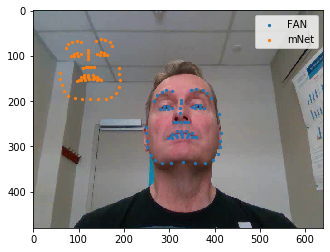

In [57]:
%matplotlib inline
n = 270
plt.imshow(imgs[n].permute(1,2,0)/255)


plt.scatter(x_fan.iloc[n][1:],y_fan.iloc[n][1:],s=5, label='FAN')
plt.scatter(x_mnet.iloc[n][1:-1],y_mnet.iloc[n][1:-1],s=5, label='mNet')
#plt.scatter(landmarks[n,:,0], landmarks[n,:,1],s=5, color='red')
plt.legend()

# Get the 3d metric measures 

In [20]:
def get3dlandmarks(BAG_File, info_file, csv_file):

    DF_landmarks = pd.read_csv(csv_file, index_col=0)

    DF_info = pd.read_csv(info_file, index_col=0)


    # create dataframe to store information about 3d position of landmarks
    df_cols_p1 = ["Video_Frame_number", 'Time_Stamp (s)']
    for i in range(0, 68):
        num = str(i)
        xx = 'landmark_' + num
        df_cols_p1.append(xx)
        df_cols_p1.append(xx)
        df_cols_p1.append(xx)

    df_cols_p2 = ["",""]
    for i in range(0, 68):
        df_cols_p2.append("x")
        df_cols_p2.append("y")
        df_cols_p2.append("z")

    header = [np.array(df_cols_p1),
              np.array(df_cols_p2)]

    DF_3dpositions = pd.DataFrame(columns=header)

    DF_3dpositions['Time_Stamp (s)'] = DF_landmarks['Time_Stamp (s)']
    DF_3dpositions['Video_Frame_number'] = DF_landmarks['Video_Frame_number']

    # start the process of extracting the video information for each video
    pipeline = rs.pipeline()
    config = rs.config()

    rs.config.enable_device_from_file(config, BAG_File, repeat_playback=False)

    config.enable_all_streams()
    profile = pipeline.start(config)

    # create alignment object
    align_to = rs.stream.color
    align = rs.align(align_to)

    # Getting the depth sensor's depth scale (see rs-align example for explanation)
    depth_sensor = profile.get_device().first_depth_sensor()
    depth_scale = depth_sensor.get_depth_scale()

    # inform the device that this is not live streaming from camera
    playback = profile.get_device().as_playback()
    playback.set_real_time(False)
    duration = playback.get_duration()

    # fill holes in the depth information (based on this example: https://nbviewer.jupyter.org/github/IntelRealSense/librealsense/blob/jupyter/notebooks/depth_filters.ipynb)
    spatial = rs.spatial_filter()
    spatial.set_option(rs.option.filter_magnitude, 2)
    spatial.set_option(rs.option.filter_smooth_alpha, 0.5)
    spatial.set_option(rs.option.filter_smooth_delta, 20)
    spatial.set_option(rs.option.holes_fill, 3)

    true_frame_number = []
    frame_number = []
    time_st = []

    num_frame = 0

    try:
        while True:
            frames = pipeline.wait_for_frames(100)

            this_frame = frames.get_frame_number()  # get frame number        
            landmarks=None
            # verify that we have landmarks for this particular frame

            try:
                vid_frame = DF_info.Frame_Number_in_Video.loc[DF_info["BAG_Frame_Number"]==this_frame].values[0] 

                index_ = DF_info.index[DF_info['BAG_Frame_Number']==this_frame]

                landmarks = DF_landmarks.iloc[index_].values[0][6:]   
                landmarks = landmarks.astype('float').reshape(-1, 2)
                aligned_frames = align.process(frames)

                # take color and depth from frame, if any to these is not available then skip the frame
                aligned_frames = align.process(frames)

                # take color and depth from frame, if any to these is not available then skip the frame
                aligned_depth = aligned_frames.get_depth_frame()
                aligned_color = aligned_frames.get_color_frame()

                # validate that both frames are available
                if not aligned_depth or not aligned_color:
                    continue

                #time_stamp = frames.get_timestamp()
                #true_frame_number.append(frames.get_frame_number())
                #time_st.append(time_stamp)
                #frame_number.append(num_frame)

                # Intrinsics & Extrinsics
                depth_intrin = aligned_depth.profile.as_video_stream_profile().intrinsics
                color_intrin = aligned_depth.profile.as_video_stream_profile().intrinsics
                depth_to_color_extrin = aligned_depth.profile.get_extrinsics_to(aligned_color.profile)

                aligned_filtered_depth = spatial.process(aligned_depth)
                depth_frame_array = np.asanyarray(aligned_filtered_depth.as_frame().get_data())
                depth_frame_array = depth_frame_array * depth_scale

                coords = []

                for (c,
                     r) in landmarks:  # landmarks provide the x,y position of each landmark. x are columns and y are rows in the figure
                    # depth_value = depth_frame.get_distance(int(c),int(r))
                    # x,y,z = rs.rs2_deproject_pixel_to_point(depth_intrin, [int(c), int(r)], depth_value)
                    try:
                        depth_value = depth_frame_array[int(r), int(c)]
                    except IndexError:
                        h,w = depth_frame_array.shape
                        if r>w-1:r=h-1
                        if c>h-1:c=w-1
                        depth_value = depth_frame_array[int(r), int(c)]

                    z = depth_value
                    x = z * ((c - depth_intrin.ppx) / depth_intrin.fx)
                    y = z * ((r - depth_intrin.ppy) / depth_intrin.fy)
                    coords.append(x), coords.append(y), coords.append(z)

                DF_3dpositions.loc[index_,2:] =coords
            except IndexError:
                error= 'Error file:' + BAG_File.split(os.path.sep)[-1] +'\n' + str(this_frame)+' does not exists in color video'
                print(error)


    except RuntimeError:
        pass
    finally:
        pipeline.stop()
        
        
    landmark_file = csv_file[:-4]+'3D.csv'
    DF_3dpositions.to_csv(landmark_file)



In [ ]:
get3dlandmarks(BAG_File, info_file, csv_file)

# Testing with 1 avi File

In [6]:
vid = torchvision.io.read_video(r"/home/deniz/Code/ClinicalScore/test/A013_02_20190110_NSM_BIGSMILE_color.avi", pts_unit='sec')

In [7]:
st=time.time()
#transforms 
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])




#create batches
idx = np.arange(vid[0].shape[0])
batch_size=200
q = int(idx.shape[0] / batch_size)
block_end = q * batch_size
batch_idx = np.split(idx[:block_end], q) + [idx[block_end:]]

F,H,W,C = vid[0].shape
print(F,H,W,C)
landmarks = np.zeros((F,68,2))
o_landmarks = np.zeros((F,68,2))
c = np.zeros((F,2))
s = np.zeros((F,))

#this for facial localization 
des_dim = 128
yshift, xshift = 0, (H-W)//2
xstart = (int(W*(128/H))-des_dim)//2

ref_scale = 195 #adjust this value to have the face smaller or bigger in the image
resolution = 256
vid_crop = torch.zeros((F,C,resolution,resolution))

with torch.no_grad():
    for batch in batch_idx:
        print('batch: ', batch.shape)
        imgs = vid[0][batch,:,:,:]
        imgs = imgs.permute(0,3,1,2)#.type(torch.FloatTensor)
        imgs_bf = nn.functional.interpolate(imgs, (des_dim, int(W*(des_dim/H))))
        imgs_bf = imgs_bf[:,:,:, xstart:xstart+128]

        bboxes = torch.cat(face_detector.predict_on_batch(imgs_bf.to(device)))
        face_locs = torch.cat((bboxes[:,1:2], bboxes[:,0:1], bboxes[:,3:4], bboxes[:,2:3]), dim=1) * H + torch.tensor([int((W-H)/2), 0, int((W-H)/2), 0]) 
        

        centersx = face_locs[:,2] - (face_locs[:,2]-face_locs[:,0])/2
        centersy = (face_locs[:,3] - (face_locs[:,3]-face_locs[:,1])/2) - (face_locs[:,3]-face_locs[:,1])*0.12
        centers = torch.cat((centersx.view(-1,1),centersy.view(-1,1)), dim=1)
        print('centers: ',centers.shape)
        
        scales = ((face_locs[:,2]-face_locs[:,0]) + (face_locs[:,3]-face_locs[:,1]))/ref_scale
        print('scales: ',scales.shape)
        #if using FAN, do this
        #imgs_norm = (imgs.div_(255)
        #if using other models do this
        
        
        imgs_crop = crop_and_resize_tensor(imgs, centers, scales, resolution=resolution)
        vid_crop[batch] = imgs_crop
        imgs_crop = (imgs_crop.div(255)-MEAN[None,:,None,None]) / STD[None,:,None,None]

        outs = model_mobilenet(imgs_crop.to(device))
        print(len(outs))
        #print(outs[0].shape)
        print('out: ', outs[1].shape)
        #original[batch,:,:] = tranform_tensor(outs[-1][batch,:,:],centers,scales, resolution, inverse = True)
        landmarks[batch,:,:] = outs[-1].cpu().numpy()
        c[batch,:] = centers.cpu().numpy()
        s[batch] = scales.cpu().numpy()
        #o_landmarks[batch,:,:] = tranform_tensor(landmarks[batch,:,:].T,centers,scales, H, inverse = True)
        #x = landmarks[batch,:,0]
        #y = landmarks[batch,:,1]
        d = landmarks[batch,:,:]
        print('d: ', d.shape)
        print()
        #d = landmarks[1,:,:]
       # for b, i, j in zip(batch, x, y):
       #     o_landmarks[b,i,j] = tranform_tensor(landmarks[b,i,j].T,centers,scales, H, inverse = True)
            
        
       # o_landmarks +=original  

landmarks = _descale(landmarks,resolution)

#original = _descale(original,resolution)

#create a dataframe that will store all the information 

print(f'FPS = {F/(time.time()-st)}')

468 480 640 3
batch:  (200,)
centers:  torch.Size([200, 2])
scales:  torch.Size([200])
2
out:  torch.Size([200, 68, 2])
d:  (200, 68, 2)

batch:  (200,)
centers:  torch.Size([200, 2])
scales:  torch.Size([200])
2
out:  torch.Size([200, 68, 2])
d:  (200, 68, 2)

batch:  (68,)
centers:  torch.Size([68, 2])
scales:  torch.Size([68])
2
out:  torch.Size([68, 68, 2])
d:  (68, 68, 2)

FPS = 408.06924645193425


In [8]:
o_landmarks = np.zeros((landmarks.shape))

In [9]:
# TRANSFORMING BACK TO THE ORIGINAL COORDS

o_landmarks = np.zeros((landmarks.shape))
for f in range(landmarks.shape[0]):
   
    h = 200 * s[f]
    t = torch.eye(3)
    t[0,0] = resolution / h
    t[1,1] = resolution / h
    t[0,2] = resolution *(-c[f,0]/h + 0.5)
    t[1,2] = resolution *(-c[f,1]/h + 0.5)
    t = torch.inverse(t)
    
    for l in range(landmarks.shape[1]):
        point = landmarks[f,l,:]
        _pt = torch.tensor([point[0],point[1],1]).view(-1,1).type(torch.FloatTensor)
        
        original = torch.matmul(t,_pt)
        #print(original.shape)
        original =  original[0:-1,:]
        original = original.reshape(2,)
        #print(original.shape)
        o_landmarks[f,l,:] = original

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torc

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torc

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torc

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torc

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torc

torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torc

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

In [10]:
df_cols = []
#y_col = []
#x_col = []
for i in range(0,68):
    num=str(i)
    xx = 'landmark_'+num+'_x'
    yy = 'landmark_'+num+'_y'
    #x_col.append(xx)
    #y_col.append(yy)
    df_cols.append(xx)
    df_cols.append(yy)
l = landmarks.reshape(landmarks.shape[0],-1)
LandmarkDataFrame = pd.DataFrame(l,columns = df_cols)

o_l = o_landmarks.reshape(o_landmarks.shape[0],-1)
OLandmarkDataFrame = pd.DataFrame(o_l,columns = df_cols)

In [11]:
x_mnet = OLandmarkDataFrame
y_mnet = OLandmarkDataFrame
for col in OLandmarkDataFrame.columns:
    if 'y'in col:
        x_mnet = x_mnet.drop([col], axis = 1)
    elif 'x' in col:
        y_mnet = y_mnet.drop([col], axis = 1)

In [12]:
x_mnet

,landmark_0_x,landmark_1_x,landmark_2_x,landmark_3_x,landmark_4_x,landmark_5_x,landmark_6_x,landmark_7_x,landmark_8_x,landmark_9_x,...,landmark_58_x,landmark_59_x,landmark_60_x,landmark_61_x,landmark_62_x,landmark_63_x,landmark_64_x,landmark_65_x,landmark_66_x,landmark_67_x
0,219.875946,220.264587,222.240387,226.049561,233.879059,244.156067,256.873718,272.735352,288.138855,304.345612,...,277.101532,270.288147,267.142365,276.781860,285.051208,293.965546,302.804932,294.242249,285.649414,276.762695
1,220.908081,221.280975,223.007111,226.683044,234.109772,244.035324,256.686066,272.269012,287.118347,302.930176,...,278.158752,271.144379,267.747192,276.916504,285.332458,295.060822,303.082336,295.401123,286.530762,277.349213
2,220.117401,222.215240,223.654510,226.258362,233.376343,243.148422,254.278412,269.456757,285.700378,298.892334,...,276.998535,268.562134,262.684814,274.239960,283.197815,291.702698,302.068939,292.243378,284.326630,275.402069
3,222.685120,224.565430,227.689789,231.765854,238.451065,247.563141,259.600647,273.502319,289.511078,306.568420,...,281.486816,273.948395,270.679230,279.596222,288.150787,296.331879,303.846130,295.880646,288.151245,279.379395
4,222.603180,224.665939,227.431915,231.255371,238.008530,247.045029,259.578766,274.902283,290.486206,307.231018,...,280.595276,273.237091,269.756927,279.026886,286.568542,294.648621,302.825256,293.983917,286.515228,278.568329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,223.672348,224.875061,227.391769,231.487091,238.319305,247.696457,259.623474,274.454254,290.126404,305.827087,...,279.507355,271.584961,267.834290,277.511963,285.990051,294.402283,303.613464,294.952057,286.220184,277.174194
464,223.879303,225.006348,227.478912,231.419159,238.244461,247.861893,259.538788,273.532288,289.119202,306.286194,...,279.199585,270.866058,268.617859,276.733185,285.041565,293.557861,302.231628,294.266968,285.737915,276.957153
465,221.763367,223.840729,226.498383,230.556061,237.168365,246.897339,258.896118,273.604156,288.854431,305.933441,...,278.593018,270.365814,267.753693,275.954102,285.297607,294.134521,302.912476,294.612701,285.715668,275.933258
466,221.326965,223.062531,226.031799,230.202393,237.198517,246.870880,259.043488,273.602203,289.179749,305.456146,...,277.565613,269.591919,267.044037,275.361816,284.175232,292.381805,302.220093,293.689117,284.567688,275.131653


In [13]:
imgs = vid[0][:,:,:,:]
imgs = imgs.permute(0,3,1,2)

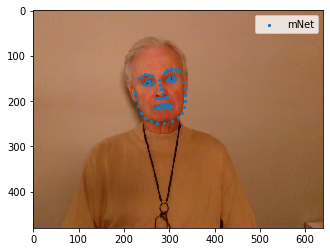

In [14]:
%matplotlib inline
n = 3
plt.imshow(imgs[n].permute(1,2,0)/255)


#plt.scatter(x_fan.iloc[n][1:],y_fan.iloc[n][1:],s=5, label='FAN')
plt.scatter(x_mnet.iloc[n][1:-1],y_mnet.iloc[n][1:-1],s=5, label='mNet')
#plt.scatter(landmarks[n,:,0], landmarks[n,:,1],s=5, color='red')
plt.legend()

In [17]:
csv_name = r'/home/deniz/Code/ClinicalScore/test/A013_02_20190110_NSM_BIGSMILE_mpix.csv'
OLandmarkDataFrame["fps"]=vid[2].get('video_fps')
OLandmarkDataFrame.to_csv(csv_name)

In [28]:
BAG_File = r'/home/deniz/Code/ClinicalScore/test/A013_02_20190110_NSM_BIGSMILE.bag'
info_file = r'/home/deniz/Code/ClinicalScore/test/A013_02_20190110_NSM_BIGSMILE_frameInfoColor.csv'
csv_file = r'/home/deniz/Code/ClinicalScore/test/A013_02_20190110_NSM_BIGSMILE_mpix.csv'

In [41]:
# working get 3D metric values of the 68 landmarks for .bag files 

def get3dlandmarks(BAG_File, info_file, csv_file):

    DF_landmarks = pd.read_csv(csv_file, index_col=0)

    DF_info = pd.read_csv(info_file, index_col=0)


    # create dataframe to store information about 3d position of landmarks
    df_cols_p1 = ['Time_Stamp (s)']
    for i in range(0, 68):
        num = str(i)
        xx = 'landmark_' + num
        df_cols_p1.append(xx)
        df_cols_p1.append(xx)
        df_cols_p1.append(xx)

    df_cols_p2 = [""]
    for i in range(0, 68):
        df_cols_p2.append("x")
        df_cols_p2.append("y")
        df_cols_p2.append("z")

    header = [np.array(df_cols_p1),
              np.array(df_cols_p2)]

    DF_3dpositions = pd.DataFrame(columns=header)

    DF_3dpositions['Time_Stamp (s)'] = DF_info['Frame_Time_Stamp']
    #DF_3dpositions['Video_Frame_number'] = DF_landmarks['Video_Frame_number']

    # start the process of extracting the video information for each video
    pipeline = rs.pipeline()
    config = rs.config()

    rs.config.enable_device_from_file(config, BAG_File, repeat_playback=False)

    config.enable_all_streams()
    profile = pipeline.start(config)

    # create alignment object
    align_to = rs.stream.color
    align = rs.align(align_to)

    # Getting the depth sensor's depth scale (see rs-align example for explanation)
    depth_sensor = profile.get_device().first_depth_sensor()
    depth_scale = depth_sensor.get_depth_scale()

    # inform the device that this is not live streaming from camera
    playback = profile.get_device().as_playback()
    playback.set_real_time(False)
    duration = playback.get_duration()

    # fill holes in the depth information (based on this example: https://nbviewer.jupyter.org/github/IntelRealSense/librealsense/blob/jupyter/notebooks/depth_filters.ipynb)
    spatial = rs.spatial_filter()
    spatial.set_option(rs.option.filter_magnitude, 2)
    spatial.set_option(rs.option.filter_smooth_alpha, 0.5)
    spatial.set_option(rs.option.filter_smooth_delta, 20)
    spatial.set_option(rs.option.holes_fill, 3)

    true_frame_number = []
    frame_number = []
    time_st = []

    num_frame = 0

    try:
        while True:
            frames = pipeline.wait_for_frames()

            this_frame = frames.get_frame_number()  # get frame number        
            landmarks=None
            # verify that we have landmarks for this particular frame

            try:
                vid_frame = DF_info.Frame_Number_in_Video.loc[DF_info["BAG_Frame_Number"]==this_frame].values[0] 

                index_ = DF_info.index[DF_info['BAG_Frame_Number']==this_frame]

                landmarks = DF_landmarks.iloc[index_].values[0][:-1]
                #print(landmarks)
                landmarks = landmarks.astype('float').reshape(-1, 2)
                aligned_frames = align.process(frames)

                # take color and depth from frame, if any to these is not available then skip the frame
                aligned_frames = align.process(frames)

                # take color and depth from frame, if any to these is not available then skip the frame
                aligned_depth = aligned_frames.get_depth_frame()
                aligned_color = aligned_frames.get_color_frame()

                # validate that both frames are available
                if not aligned_depth or not aligned_color:
                    continue

                #time_stamp = frames.get_timestamp()
                #true_frame_number.append(frames.get_frame_number())
                #time_st.append(time_stamp)
                #frame_number.append(num_frame)

                # Intrinsics & Extrinsics
                depth_intrin = aligned_depth.profile.as_video_stream_profile().intrinsics
                color_intrin = aligned_depth.profile.as_video_stream_profile().intrinsics
                depth_to_color_extrin = aligned_depth.profile.get_extrinsics_to(aligned_color.profile)

                aligned_filtered_depth = spatial.process(aligned_depth)
                depth_frame_array = np.asanyarray(aligned_filtered_depth.as_frame().get_data())
                depth_frame_array = depth_frame_array * depth_scale

                coords = []

                for (c,
                     r) in landmarks:  # landmarks provide the x,y position of each landmark. x are columns and y are rows in the figure
                    # depth_value = depth_frame.get_distance(int(c),int(r))
                    # x,y,z = rs.rs2_deproject_pixel_to_point(depth_intrin, [int(c), int(r)], depth_value)
                    try:
                        depth_value = depth_frame_array[int(r), int(c)]
                    except IndexError:
                        h,w = depth_frame_array.shape
                        if r>w-1:r=h-1
                        if c>h-1:c=w-1
                        depth_value = depth_frame_array[int(r), int(c)]

                    z = depth_value
                    x = z * ((c - depth_intrin.ppx) / depth_intrin.fx)
                    y = z * ((r - depth_intrin.ppy) / depth_intrin.fy)
                    coords.append(x), coords.append(y), coords.append(z)

                DF_3dpositions.loc[index_,1:] =coords
                
            except IndexError:
                error= 'Error file:' + BAG_File.split(os.path.sep)[-1] +'\n' + str(this_frame)+' does not exists in color video'
                print(error)


    except RuntimeError:
        pass
    finally:
        pipeline.stop()
        
    DF_3dpositions['depth_scale'] = depth_scale  
    landmark_file = csv_file[:-4]+'3D.csv'
    DF_3dpositions.to_csv(landmark_file)

In [ ]:
for index, row in oldlookup_df.iterrows():
        # Read all data from the input dataframe
    
    try:
        color_path = row['color_file']
        depth_path = row['depth_file']
        print("Starting: ", color_path)
        #info_path = row['cvs_frame_info_Files']
        pixel_path = row['srb_pixel_file']
        if os.path.exists(depth_path) and os.path.exists(pixel_path):
            get3dlandmarks_video(depth_path, pixel_path)
        
        
    except KeyError:
        raise KeyError("Input csv must contain 'csv_path', 'rest_path', 'rest_table_path' \
        'task', 'subject', and 'type' columns. \nFurthermore, 'csv_path' \
        and 'rest_path' must be files on the disk.")
        print('THSI FILE HAS ERROR')
        print()
        continue 


In [24]:
#landmarks = _descale(landmarks,resolution)
%matplotlib qt
plt.plot(np.linalg.norm(landmarks[:,57,:]-landmarks[:,51,:], axis=1),'--o')
    



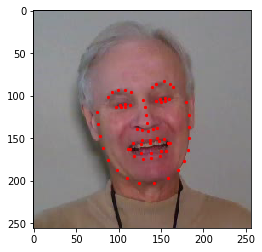

In [28]:
%matplotlib inline
n = 170
plt.imshow(vid_crop[n].permute(1,2,0)/255)
plt.scatter(landmarks[n,:,0], landmarks[n,:,1],s=5, color='red')

#plt.imshow(vid[0][n])

In [ ]:
imgs = vid[0][:,:,:,:]
imgs = imgs.permute(0,3,1,2)

In [ ]:
%matplotlib inline

plt.imshow(imgs[n].permute(1,2,0)/255)


#plt.scatter(x_fan.iloc[n][1:],y_fan.iloc[n][1:],s=5, label='FAN')
#plt.scatter(x_mnet.iloc[n][1:-1],y_mnet.iloc[n][1:-1],s=5, label='mNet')
plt.scatter(original[n,:,0], original[n,:,1],s=5, color='red')
plt.legend()

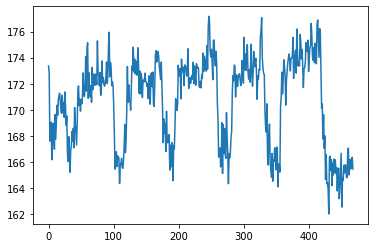

In [29]:
plt.plot(landmarks[:,57,1])

In [ ]:
center = centers
scale = scales

N,C,H,W = imgs.shape
ul_b = tranform_tensor([1,1],center,scale, resolution, inverse = True)
br_b = tranform_tensor([resolution,resolution],center,scale, resolution, inverse = True)
out_imgs = torch.zeros((N,C,resolution,resolution))
for ul_t,bl_t, k in zip(ul_b,br_b, np.arange(N)):
    ul=np.round(ul_t.numpy(),0).astype(np.int)
    br=np.round(bl_t.numpy(),0).astype(np.int)
    newImg = torch.zeros([C,int(br[1]-ul[1]),int(br[0]-ul[0])]).int()
    newX = np.array(
    [max(1, -ul[0] + 1), min(br[0], W) - ul[0]], dtype=np.int32)
    newY = np.array(
    [max(1, -ul[1] + 1), min(br[1], H) - ul[1]], dtype=np.int32)
    oldX = np.array([max(1, ul[0] + 1), min(br[0], W)], dtype=np.int32)
    oldY = np.array([max(1, ul[1] + 1), min(br[1], H)], dtype=np.int32)

    #newImg[:,int(newY[0]) - 1:int(newY[1]), int(newX[0]) - 1:int(newX[1])
    #   ] = image[:,int(oldY[0]) - 1:int(oldY[1]), int(oldX[0]) - 1:int(oldX[1])]

    newImg[:,int(newY[0]):int(newY[1]), int(newX[0]):int(newX[1])] = imgs[k][:,int(oldY[0]):int(oldY[1]), int(oldX[0]):int(oldX[1])]
    out_imgs[k] = nn.functional.interpolate(newImg.unsqueeze(0).float(), size=(resolution, resolution))


In [ ]:
plt.imshow(out_imgs[50].permute(1,2,0)/255)

In [ ]:
F

# Random Testing of Code Pieces

In [ ]:

#OPEN CV FRAME TESTING  

for k in range(int(num_frames)):
    current_frame_num  = int(video_handler.get(cv2.CAP_PROP_POS_FRAMES))
    print(current_frame_num )
    current_time_stamp = video_handler.get(cv2.CAP_PROP_POS_MSEC)/1000
    print(current_time_stamp)
    success, image = video_handler.read()